## INFO284 - Group exam

Your tasks are:

#### Preprocessing: 
Get to understand the data and remove columns and rows that you do not find useful for your machine learning models. It is possible to for example focus on one type of gear, one or a few species, group categories of species, etc. etc. This will help to reduce
the data set you are working on. Understanding data and preparing them for model building
is a main task of machine learning.

#### Supervised learning: 
Build at least three machine learning models to predict or classify catch
data related to a fishery operation, i.e. species caught, amounts of one fish species (sums of amounts is also possible), or other features related to fish catches. One of the models needs to be a deep learning model.

#### Unsupervised learning: 
Build a clustering model for the data set. You may use a different preprocessing for this task than for the data in task b).


You shall deliver code in the form of a well commented Jupyter notebook. This code needs to run on the original data set, so any preprocessing you choose to do needs to be programmed in Python and included in the notebook. The code shall in the end return the results of your experiments with your chosen models. You need to explain

- Important and relevant properties of the data
- how you preprocessed data like which features you selected, did you do dimension reduction 
- how you reformatted data, etc.
- how you decided on parameters for your machine learning models,
- if you used any regularization techniques? In case how.
- how the methods were measured and compared

Please inform about any special Python libraries that need to be installed to make your code runnable.

Finally, as a concluding comment in the Jupyter notebook, you need to write a summary of your results, and discuss consequences of such results.

It is not necessarily so that high scores for machine learning models will give a good grade on your report, or vice versa, low scores a bad grade. What counts is a well-argued, well described, and smart machine learning investigation from start to end. The problem may in fact be of such nature that it is not possible to get really good results on these data.
Final note: These data are prepared for this course and are shared with you in confidence that you do not share them in any way but use them only for the purpose of this exam.


# 1.0: Preprosessering


## 1.1: Importerer nødvendige biblioteker
Vi starter med å åpne csv-filen som inneholder datasettet vi skal arbeide videre med, og å importere nødvendige moduler til senere bruk. Filen inneholder en rekke data om fisketurer og fangst, og er inndelt i kolonner og rader.

Filen skiller de ulike elementene i en rad med ";", mens standard separator er ",". På samme måte brukes det i filen "," for å angi desimaler, mens standard er "." Vi må derfor angi hvordan maskinen skal lese filen ved å angi ny separator og desimaltegn, slik at maskinen leser dataene på korrekt måte.

In [400]:
import pandas as pd
import numpy as np
from sklearn import linear_model  # For den lineære modellen.
from sklearn.model_selection import train_test_split  # For å splitte datasettet.
import datetime as dt
import matplotlib.pyplot as plt  # For statistikk og grafiske fremstillinger.
import seaborn as sns  # For statistikk og grafiske fremstillinger
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler  # For å skalere

from sklearn.metrics import mean_squared_error # For å måle resultat

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import datasets

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')

## 1.2: Splitte datasett
Vi splitter datasettet vårt inn i train og test data tidlig. Dette er fordi at modellene kan «huske» settet som den bygges opp av (train settet), og vil dermed alltid yte godt på dette settet. Vi får imidlertid ikke muligheten til å se hvor godt modellene fungerer på ny data. For å kunne vurdere modellenes ytelse, må vi altså vise modellene ny data når de skal testes, altså data som modellen ikke tidligere har sett (Müller & Guido, 2017).

Ved å splitte datasettet vårt tidlig sørger vi altså for at modellene ikke allerede har "sett" test dataene slik at vi risikerer uriktige resultater når vi skal vurdere hvor gode modellene vi har bygd opp er.


In [401]:
# Splitter datasettet i train_df og test_df
train_df, test_df = train_test_split(df, test_size = 0.15)

## 1.3: Utforske datasettet:
Før man skal bygge maskinlæringsmodeller, bør man aller først utforske datasettet man skal jobbe med (Müller & Guido, 2017). Vi starter derfor med å undersøke hva datasettet inneholder av informasjon, og hvordan dataen er organisert. 

In [402]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259618 entries, 29017 to 44182
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                259618 non-null  int64  
 1   Meldingstidspunkt         259618 non-null  object 
 2   Meldingsdato              259618 non-null  object 
 3   Meldingsklokkeslett       259618 non-null  object 
 4   Starttidspunkt            259618 non-null  object 
 5   Startdato                 259618 non-null  object 
 6   Startklokkeslett          259618 non-null  object 
 7   Startposisjon bredde      259618 non-null  float64
 8   Startposisjon lengde      259618 non-null  float64
 9   Hovedområde start (kode)  257911 non-null  float64
 10  Hovedområde start         256112 non-null  object 
 11  Lokasjon start (kode)     257911 non-null  float64
 12  Havdybde start            259618 non-null  int64  
 13  Stopptidspunkt            259618 non-null  obj

Av df.info ser vi tittel på de ulike kolonnene og hvilken datatype de inneholder. I tillegg ser vi hvor mange "non-null" verdier som eksisterer. Her ser vi at det eksisterer null-verdier i de fleste kolonner. Dette indikerer at de kan  finnes overflødige felter som kan renses bort på et senere tidspunkt.

**Organisering av datasettet**

Datasettet er videre organisert slik at hver rad inneholder informasjon om fangst av en art, herunder blant annet informasjon om tidspunkt, lokasjon, båtstørrelse, mengde fisk og fiskeart. Vi bemerker oss særlig to ting; informasjon om samme fiskeaktivitet er registrert over flere rader, og det eksisterer to kolonner for bruttotonnasje.

***Fiskeaktivitet:***

Vi ser at flere rader kan inneholde informasjon om samme fisketur, hvor blant annet start og sluttidspunkt er den samme. De ulike fangstene som er gjort på samme tidspunkt med samme meldingID ser altså ut til å være knyttet til samme fiskeaktivitet. 

***Bruttotonnasje:***

Vi ser videre at det finnes to ulike kolonner for Bruttotonnasje. "Bruttotonn er totalvolumet av alle lukkede rom som er i bruk på et skip." (Osnes, 2024). Bruttotonnasje sier altså noe om det totale volumet av hulrom i båten. Selv om det ikke kan sammenlignes med lastekapasitet, kan det være en indikator på dette.


**Videre undersøkelser**

Vi ønsker som utgangspunkt å se om det er mulig å predikere rundvekt av en bestemt art med den informasjonen vi har. Siden fiskere bruker ulike redskaper for å fange fisk, kan vi anta at noen redskaper og metoder er mer egnet for å fange bestemte arter. Vi vet også at det foregår fiske etter ulike arter på ulike steder og tidspunkt. Kunnskap om hvordan, hvor og hva som fiskes etter er derfor viktig for å forstå datasettet. Videre vil vi undersøke denne type informasjonen.

In [403]:
# Først undersøker vi hvor mange registreringer det er av de ulike fisketypene og hvor mye det fiskes av hver.

species_weight_sum = train_df.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Art - gruppe'].value_counts())
print(species_weight_sum)

Art - gruppe
Torsk                                       48191
Annen torskefisk                            38583
Sei                                         36155
Hyse                                        33194
Annen flatfisk, bunnfisk og dypvannsfisk    21478
Uer                                         16678
Steinbiter                                  13828
Dypvannsreke                                11639
Blåkveite                                    6808
Sild, annen                                  5130
Snøkrabbe                                    5120
Skater og annen bruskfisk                    3463
Makrell                                      2522
Kolmule                                      2422
Øyepål                                       1908
Annen pelagisk fisk                          1533
Vassild og strømsild                         1390
Andre skalldyr, bløtdyr og pigghuder         1136
Lodde                                        1003
Tobis og annen sil                   

Observerer en hovedvekt av fiske etter torsk og sei. 

Vi ser videre på hvilke redskaper som brukes hyppigst, og hvor hvor mye total rundvekt de ulike redskapene er registrert med.

In [404]:
# Gjør samme undersøkelse av redskaper.

redskap_weight_sum = train_df.groupby('Redskap FDIR')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Redskap FDIR'].value_counts())
print(redskap_weight_sum)

Redskap FDIR
Bunntrål                                  102457
Snurrevad                                  43829
Andre liner                                37422
Reketrål                                   19103
Udefinert garn                             16333
Udefinert trål                             13487
Snurpenot/ringnot                          10757
Teiner                                      5748
Bunntrål par                                2839
Dobbeltrål                                  2470
Flytetrål                                   2339
Flytetrål par                               1288
Settegarn                                    553
Harpun og lignende uspesifiserte typer       403
Annet                                        399
Juksa/pilk                                    17
Dorg/harp/snik                                15
Name: count, dtype: int64
Redskap FDIR
Snurpenot/ringnot                         663729510.0
Flytetrål                                 400936599.0
Bunntrå

Brunntrål og Snurrevad viser seg å være de mest brukte fangstredskapene, etterfulgt av andre liner og reketrål.

Vi vet fra fiskeridirektoratet at bunntrål og snurrevad er fiskeredskaper som samler fisk ved å slepe eller trekke garn/not gjennom vannet. "Andre liner" er fiskeredskaper med agn og krok som kan settes ut (Fiskeridirektoratet, 2022).

Vi har nå fått en oversikt over hvilke fisker som fiskes, og hvilke redskaper som brukes. Videre er det naturlig å undersøke hvordan sammensetningen av fisk er med de ulike fangstmetodene, og hvor vanlig metodene er. 

Vi har valgt å fokusere spesielt på bunntrål og snurrevad, ettersom vi har mye data på disse redskapene, og de har noe lik fangstmetodikk. 

In [405]:
# Ser etter hvilke fisk som blir fisket med Bunntrål:
condition = train_df[train_df['Redskap FDIR'] == 'Bunntrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       19919
Sei                                         15533
Hyse                                        14187
Annen torskefisk                            12714
Uer                                         12057
Annen flatfisk, bunnfisk og dypvannsfisk     7307
Dypvannsreke                                 6310
Steinbiter                                   6209
Blåkveite                                    4335
Skater og annen bruskfisk                     678
Øyepål                                        621
Andre skalldyr, bløtdyr og pigghuder          508
Vassild og strømsild                          412
Kolmule                                       410
Annen pelagisk fisk                           336
Sild, annen                                   266
Makrell                                       208
Tobis og annen sil                            149
Lodde                                          52
Haifisk                              

In [406]:
# Ser etter hvilke fisk som blir fisket med Snurrevad:
condition = train_df[train_df['Redskap FDIR'] == 'Snurrevad']

species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       13906
Hyse                                        10132
Sei                                          9528
Annen flatfisk, bunnfisk og dypvannsfisk     3576
Annen torskefisk                             3492
Steinbiter                                   1110
Uer                                           683
Blåkveite                                     312
Sild, annen                                    26
Makrell                                        19
Dypvannsreke                                   10
Skater og annen bruskfisk                       9
Lodde                                           9
Andre skalldyr, bløtdyr og pigghuder            4
Haifisk                                         2
Annen pelagisk fisk                             1
Sjøpattedyr                                     1
Name: count, dtype: int64 Art - gruppe
Torsk                                       48922141.0
Sei                                        

Etter å ha studert de ulike redskapene og hva som blir fisket med dem, observeres også konturene av hvordan de blir brukt. Bunntrål fanger blandt annet mest torsk og sei, men også mye av andre arter. Dette er det redskapet som vi har undersøkt som har jevnest fordeling av arter, som betyr at det er det redskapet som bidrar med mest bifangst. Snurrevad gir også mye torsk og sei, men virker å være et noe mer målrettet fiskeredskap, ettersom spredningen av fangst av forskjellige arter ikke er like stor. 

Basert på denne informasjonen er det interessant å dykke videre inn i et bestemt redskap og art, og se på muligheten for å begrense oss til et bestemt havområde. 

Vi danner oss derfor en oversikt over de ulike fiskeområdene og ser på fordelingen registreringer som er gjort per område.


In [407]:
print(train_df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  38546
Røstbanken til Malangsgrunnen    24700
Vest-Finnmark                    23624
Øst-Finnmark                     22879
Bjørnøya                         21678
Shetland                         21051
Nordkappbanken                   15826
Vikingbanken                     14153
Skagerrak                        13672
Storegga-Frøyabanken             12597
Helgelandsbanken                  7318
Sentralbanken                     4739
Storbanken                        4078
Thor Iversens Bank                3818
Vestfjorden (Lofoten)             3798
Sentrale Nordsjø                  2865
Hopen                             2721
Vest av Skottland (Hebridene)     1724
Sørlige Norskehav                 1665
Østlige Norskehav                 1649
Admiralityfeltet                  1625
Skolpenbanken                     1604
Gåsebanken                        1433
Storfjord/Hinlopenstredet         1151
Vest-Spitsbergen                  1044
Vest av

### 1.3.1 Konklusjon av første titt på data:
Med utgangspunkt i dataen, ønsker vi å filtrere ut data etter følgende betingelser: Hovedart - Sei, Område - Norskekysten, fangstredskap - Trål.

Vi har valgt å fokusere på seifiske, siden dette er en av de fiskene som blir fisket hyppigst i Norge i følge dataen.

Når det gjelder lokasjon, er det hovedsaklig fiske etter to grupper av sei. En gruppe som beiter i havområdene mellom Norge og Skottland (Havforskningsinstituttet, 2019), og en annen som beiter i kystområdene fra vestlandet til finnmark (Havforskningsinstituttet 2019).

Dersom vi ønsker å fokusere på den nordøstarktiske seien, kan basert på informasjonen være lurt å fokusere på hovedområdene med kode fra 0,1, 3-7 og 28. Om vi skal inkludere Nordsjøseien, så kan  områdene 40-43 inkluderes, men da beveger vi oss litt utenfor de de norske områdene. 

Siden det eksisterer et så stort omfang av trålfiske, så eksisterer det også mye data. Trål er også det redskapet som er mest brukt for å fiske sei.

For å finne oversikt over de aktuelle hovedområdene, benyttes karttjenesten til fiskeridirektoratet (Fiskeridirektoratet, 2018).

## 1.4: Filtrere data
Spesifiserer for train-settet at vi vil se på sei-fiske, nordøstlige områder og bunntrål, og filtrerer bort alle rader som ikke inneholder disse verdiene. Gjør og det samme for test-settet.

Tar utgangspunkt i alle radene hvor sei er angitt som Hovedart, som innebærer at bifangst på turer hvor sei er registrert som hovedart også blir inkludert. Det betyr dog at rader hvor sei er registrert som bifangst blir kuttet. 

Videre ser vi en beskrivelse av dataene som er registrert på seifiske, og en oversikt over normalfordeling av dataene.

In [408]:
# Lager en betingelse med aktuelle områder.
northeastern = [0, 1, 3, 4, 5, 6, 7, 28]
northeastern_ocean = [30, 34, 37, 39, 12, 36] # For å undersøke om det er noe særlig seifiske utenfor de mer kystnære strøk
northsea = [40, 41, 42, 43] # For å undersøke seifiske
# Legger inn betingelser i train_df.
filtered_train_df = train_df[
    (train_df['Hovedart FAO'] == 'Sei') &
    (train_df['Hovedområde start (kode)'].isin(northeastern)) &
    (train_df['Redskap FDIR'] == 'Bunntrål')
]

# Gjør det samme med test-settet
filtered_test_df = test_df[
    (test_df['Hovedart FAO'] == 'Sei') &
    (test_df['Hovedområde start (kode)'].isin(northeastern)) &
    (test_df['Redskap FDIR'] == 'Bunntrål')
]

filtered_train_df.describe()  # Får her et inntrykk av ekstremverdier og gjennomsnitt.

Melding ID  Startposisjon bredde  Startposisjon lengde  \
count  2.297300e+04          22973.000000          22973.000000   
mean   1.646438e+06             66.722142             13.005000   
std    9.441378e+04              4.129374              8.333179   
min    1.497341e+06             60.001000              2.006000   
25%    1.549212e+06             62.837000              5.327000   
50%    1.665665e+06             68.052000             10.885000   
75%    1.729002e+06             70.871000             20.568000   
max    1.800286e+06             71.998000             32.279000   

       Hovedområde start (kode)  Lokasjon start (kode)  Havdybde start  \
count              22973.000000           22973.000000    22973.000000   
mean                   8.616332              19.164193     -189.120489   
std                    8.316811              13.900032       64.960509   
min                    0.000000               1.000000     -761.000000   
25%                    4.000000               9.000000     -226.000000   
50%                    5.000000              15.000000     -183.000000   
75%                    7.000000              23.000000     -146.000000   
max                   28.000000              54.000000        1.000000   

           Varighet  Fangstår  Stopposisjon bredde  Stopposisjon lengde  ...  \
count  22973.000000   22973.0         22973.000000         22973.000000  ...   
mean     255.393244    2018.0            66.738212            13.039909  ...   
std       89.186976       0.0             4.140894             8.351449  ...   
min        6.000000    2018.0            59.647000             1.654000  ...   
25%      195.000000    2018.0            62.839000             5.343000  ...   
50%      266.000000    2018.0            68.097000            10.987000  ...   
75%      321.000000    2018.0            70.884000            20.596000  ...   
max     1706.000000    2018.0            72.060000            32.226000  ...   

       Redskap FDIR (kode)  Hovedart - FDIR (kode)  Art - FDIR (kode)  \
count              22973.0                 22973.0       22973.000000   
mean                  51.0                  1032.0        1235.081443   
std                    0.0                     0.0         452.256289   
min                   51.0                  1032.0         529.000000   
25%                   51.0                  1032.0        1023.000000   
50%                   51.0                  1032.0        1032.000000   
75%                   51.0                  1032.0        1034.000000   
max                   51.0                  1032.0        2919.000000   

       Art - gruppe (kode)      Rundvekt  Lengdegruppe (kode)  \
count         22973.000000  22973.000000         22973.000000   
mean            224.915727   2688.123580             4.935838   
std              39.685328   5382.696142             0.283278   
min             201.000000      0.000000             3.000000   
25%             202.000000     76.000000             5.000000   
50%             203.000000    262.000000             5.000000   
75%             220.000000   2423.000000             5.000000   
max             520.000000  86506.000000             5.000000   

       Bruttotonnasje 1969  Bruttotonnasje annen        Bredde  Fartøylengde  
count         22274.000000            699.000000  22973.000000  22973.000000  
mean           1954.682769            165.824034     12.918661     57.238554  
std            1074.893410             16.267347      2.259620     15.123547  
min             197.000000            129.000000      7.000000     19.750000  
25%            1199.000000            173.000000     12.200000     50.800000  
50%            1598.000000            173.000000     13.000000     56.800000  
75%            2610.000000            173.000000     14.600000     69.800000  
max            4427.000000            173.000000     16.700000     81.200000  

[8 rows x 24 columns]

## 1.5: Gruppere data og fjerne kolonner:
Vi gruppere data ved å slå sammen rader som gjelder samme fiskeaktivitet. Det kan argumenteres for at det ville vært gunstig å gjort tidligere, dog kunne man ha oversett nyanser i datasettet. 

Ved å observere dataen først lærte vi at for hver fiskeaktivitet så er det registrert flere arter og rundvekt av hver art, selv om hovedarten er den samme. Dersom man ikke har et bilde av hvordan fordelingen av rundvekt er, så kan man senere få utfordringer med modellene. Derfor er vi bevisste på at det å slå disse registreringene av rundvekt sammen, beregnes også rundvekten for hele fangsten, ikke bare rundvekten av hovedarten.

F.eks. ved å predikere fangst basert på redskapet trål, gitt omfanget av oppgaven, er det naturlig å regne rundvekt basert på hele fangsten, dog med fokus på en bestemt art.

Vi har gjort en antakelse om at total rundvekt kan gi oss en pekepinn på hva en god fangst er, uavhengig av hvilke arter som er fanget. Kanskje er målrettet fiske i realiteten mer lønnsomt, men når man fisker med trål så er mangfoldet av arter som fanges en del av bildet og gir en større total rundvekt.

In [409]:
# Funksjon for å samle de sammenslåtte dataene som tekststreng.
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

grouped_df = filtered_train_df.groupby(['Melding ID', 'Meldingstidspunkt'], as_index=False).agg({
    'Melding ID': 'first', # Trengs muligens for å skille aktiviterer fra ulike båter.
    'Meldingstidspunkt': 'first', 
    'Meldingsdato': 'first',
    'Meldingsklokkeslett': 'first', 
    'Starttidspunkt': 'first', 
    'Startdato': 'first',
    'Startklokkeslett': 'first', 
    'Startposisjon bredde': 'first', 
    'Startposisjon lengde': 'first',
    'Hovedområde start (kode)': 'first', 
    #'Hovedområde start': 'first',  # Vi forholder oss til koden, da blir denne kolonnen irrelevant
    #'Lokasjon start (kode)': 'first', # Mye tomme celler, dokumentasjonen advarer om å bruke denne kolonnen.
    'Havdybde start': 'first', 
    'Stopptidspunkt': 'first', 
    'Stoppdato': 'first', 
    'Stoppklokkeslett': 'first', 
    'Varighet': 'first', 
    #'Fangstår': 'first', Så og si alle fangstdata er registrert i 2018.
    'Stopposisjon bredde': 'first', 
    'Stopposisjon lengde': 'first',
    # 'Hovedområde stopp (kode)': 'first', # Vi forholder oss til området hvor fisket starter. 
    #'Hovedområde stopp': 'first', 
    #'Lokasjon stopp (kode)': 'first', # Unødvendig å ha med videre.
    'Havdybde stopp': 'first', 
    'Trekkavstand': 'first',
    #'Redskap FAO (kode)': 'first', # Unødvendig med flere kolonner av redskaper
    #'Redskap FAO': 'first', 
    #'Redskap FDIR (kode)': 'first',
    'Redskap FDIR': 'first', # Vi forholder oss FDIR sine kolonner av redskaper.
    #'Hovedart FAO (kode)': 'first', 
    'Hovedart FAO': 'first',
    #'Hovedart - FDIR (kode)': 'first', 
    #'Art FAO (kode)': join_unique_values, # Sletter bifangst radene, siden vi ikke er interessert i å se på bifangst. 
    #'Art FAO': join_unique_values,
    #'Art - FDIR (kode)': join_unique_values, 
    #'Art - FDIR': join_unique_values, 
    #'Art - gruppe (kode)': 
    #'Art - gruppe': 'Join_unique_values' 
    'Rundvekt': 'sum', # Summerer sammen fangsten på en aktivitet.
    'Lengdegruppe (kode)': 'first', 
    'Lengdegruppe': 'first',
    'Bruttotonnasje 1969': 'first', 
    'Bruttotonnasje annen': 'first', 
    'Bredde': 'first',
    'Fartøylengde': 'first'
    })

grouped_df.head()

Melding ID Meldingstidspunkt Meldingsdato Meldingsklokkeslett  \
0     1497341  01.01.2018 23:30   01.01.2018               23:30   
1     1497435  02.01.2018 07:50   02.01.2018               07:50   
2     1497823  02.01.2018 23:31   02.01.2018               23:31   
3     1497827  02.01.2018 23:31   02.01.2018               23:31   
4     1497843  02.01.2018 23:45   02.01.2018               23:45   

     Starttidspunkt   Startdato Startklokkeslett  Startposisjon bredde  \
0  01.01.2018 18:54  01.01.2018            18:54                61.283   
1  01.01.2018 03:21  01.01.2018            03:21                68.256   
2  02.01.2018 00:20  02.01.2018            00:20                68.535   
3  02.01.2018 21:48  02.01.2018            21:48                69.483   
4  02.01.2018 16:52  02.01.2018            16:52                63.122   

   Startposisjon lengde  Hovedområde start (kode)  ...  Trekkavstand  \
0                 2.074                      28.0  ...       16590.0   
1                10.828                       5.0  ...       43775.0   
2                11.986                       5.0  ...       35125.0   
3                15.850                       5.0  ...        4006.0   
4                 5.381                       7.0  ...       34192.0   

  Redskap FDIR Hovedart FAO Rundvekt  Lengdegruppe (kode)  Lengdegruppe  \
0     Bunntrål          Sei   3000.0                  5.0  28 m og over   
1     Bunntrål          Sei  56798.0                  5.0  28 m og over   
2     Bunntrål          Sei  16837.0                  5.0  28 m og over   
3     Bunntrål          Sei   5140.0                  4.0    21-27,99 m   
4     Bunntrål          Sei   1685.0                  5.0  28 m og over   

   Bruttotonnasje 1969  Bruttotonnasje annen  Bredde Fartøylengde  
0               2053.0                   NaN   13.00        75.50  
1               2580.0                   NaN   14.60        64.00  
2               2580.0                   NaN   14.60        64.00  
3                  NaN                 129.0    7.01        25.07  
4                536.0                   NaN   10.30        33.95  

[5 rows x 28 columns]

## 1.6: Utforske datasettet på nytt
Etter en grov filtering og gjennomgang av datasettet ønsker vi å spisse arbeidet videre mot en bestemt art, redskap og lokasjon. Derfor filteres det videre for å luke ut overføldig og gjentakense data.
I følge Müller & Guido (2017) er den beste måten å utforske datasettet på å visualisere dataene. Vi vil i tillegg forsøke å gruppere noen av dataene for å redusere dimensjonene av datasettet. 

### 1.6.1 Rundvekt

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


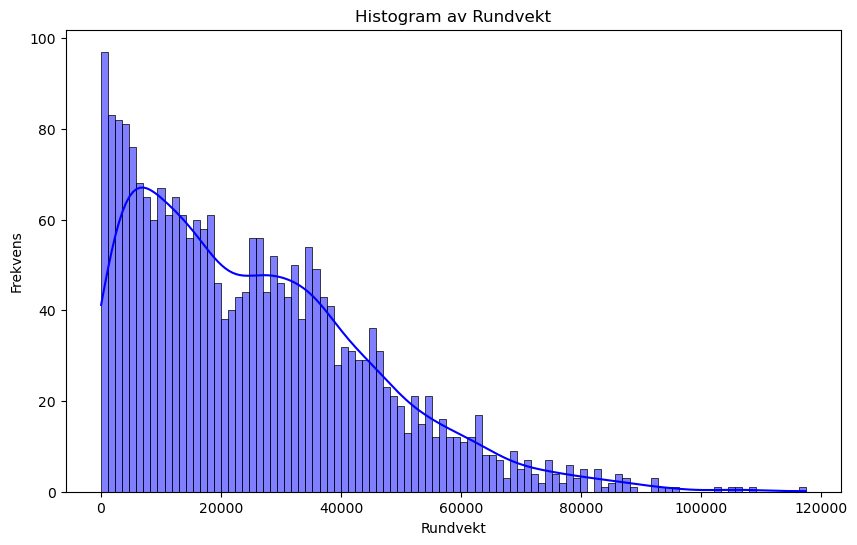

In [410]:
import seaborn as sns

# Ser på fordelingen av rundvekt.
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Rundvekt'], kde=True, bins=100, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


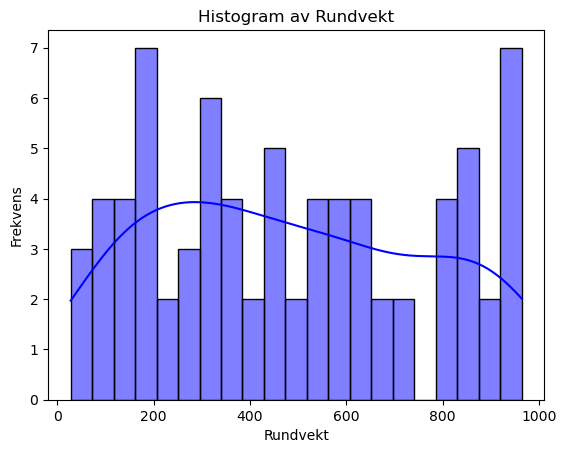

In [411]:
rundvekt = grouped_df[grouped_df['Rundvekt']< 1000]
sns.histplot(rundvekt['Rundvekt'], kde=True, bins=21, color='blue')
plt.title('Histogram av Rundvekt')
plt.xlabel('Rundvekt')
plt.ylabel('Frekvens')
plt.show()

Observerer at det eksisterer en del "bomturer" hvor fiskeaktiviteten ikke har gitt fangst. Dette vil vi komme tilbake til når vi skal rense data i punkt 7.

In [412]:
log_rundvekt = np.log(filtered_train_df['Rundvekt'])
log_rundvekt.skew()

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/pandas/core/nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


nan

### 1.6.2 Bruttotonnasje:
Det er vanskelig å vite hvilke mål på skipet som er de beste for å anslå skipets lastekapasitet, men vi har landet på bruttotonnasje som det beste målet. 

For å bruke bruttotonnasje-kolonnene er vi nødt til å kombinere kolonnene "bruttotonnasje 1969" og "bruttotonnasje annen". I vedlegg til oppgaven står det følgende om bruttotonnasje 1969: "I denne variabelen, «Bruttotonnasje 1969», er det i dag ført bruttotonnasje for fartøy med lengde (L) større eller lik 24 meter (L), målt og berekna i medhald av internasjonal konvensjon om måling av fartøy, 1969 (London-konvensjonen 1969)."

Altså skip under 24m er ført i bruttotonnasje annen og de resterende i 1969. Siden ingen rader har verdier i begge kolonnene kan vi enkelt så de sammen.

In [413]:
# Slår sammen bruttotonnasje-gruppene.
grouped_df.loc[:, 'Bruttotonnasje kombinert'] = grouped_df['Bruttotonnasje 1969'].fillna(grouped_df['Bruttotonnasje annen'])

/opt/homebrew/anaconda3/envs/info284/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


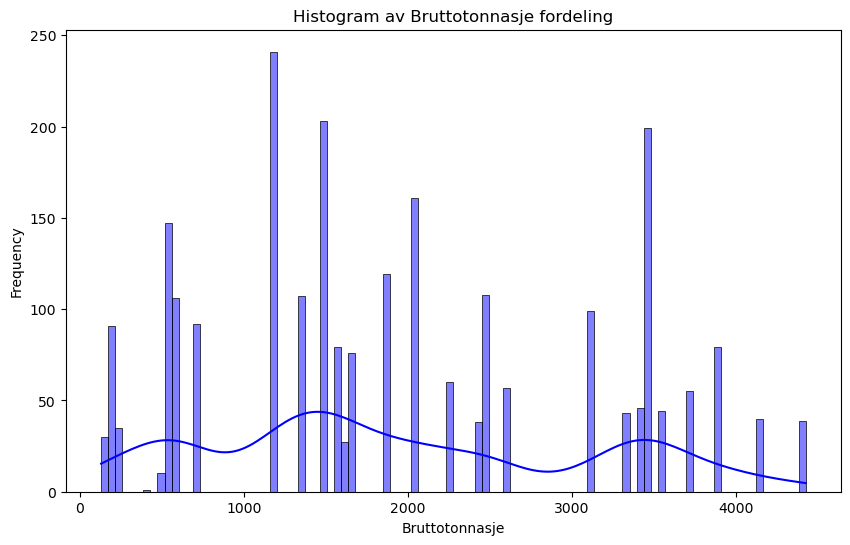

In [414]:
# Lager grafisk fremstilling av fordeling av båtstørrelse
plt.figure(figsize=(10, 6))
sns.histplot(grouped_df['Bruttotonnasje kombinert'], kde=True, bins=100, color='blue')
plt.title('Histogram av Bruttotonnasje fordeling')
plt.xlabel('Bruttotonnasje')
plt.ylabel('Frequency')
plt.show()

Ser tendenser av at båtstørrelsen deles grovt inn i tre kategorier: "Småbåter" under 1000 bruttotonn, "mellomstore" fra 1000 til 3000 og "store" over 3000. vi velger å gruppere båtene inn i disse tre gruppene.

In [415]:
# Grupperer Bruttotonnasje-kolonnen
bins = [0, 1000, 2000, 3000, 4000]
labels = [1, 2, 3, 4]
grouped_df['Bruttotonnasje gruppert'] = pd.cut(grouped_df['Bruttotonnasje kombinert'], bins=bins, labels=labels)

grouped_df['Bruttotonnasje gruppert'].value_counts()

Bruttotonnasje gruppert
2    852
4    565
1    512
3    424
Name: count, dtype: int64

### 1.6.3 Tidspunkt
Se hvordan aktiviteten er fordelt på måneder og timer.
Etter å ha testet de ulike kolonnene basert på fordeling av tid, observeres mange registreringer på startklokkeslett 00.00.



In [416]:
# Grupperer startklokkeslett i grupper etter timer slik at.
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M')
grouped_df['Hours'] = grouped_df['Startklokkeslett'].dt.hour
print(grouped_df['Hours'].value_counts())

# Grupperer meldingsdato etter måneder.
grouped_df['Meldingsdato'] = pd.to_datetime(grouped_df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
grouped_df['Month'] = grouped_df['Meldingsdato'].dt.month
print(grouped_df['Month'].value_counts())

Hours
0     122
6     120
11    113
22    111
5     109
3     108
23    107
13    106
9     103
10    103
18    103
17    103
7     102
14    100
21    100
19     98
16     96
12     94
4      92
15     91
2      88
20     88
8      88
1      87
Name: count, dtype: int64
Month
3     326
2     316
7     220
9     218
4     199
1     188
12    180
11    177
6     175
8     156
5     149
10    128
Name: count, dtype: int64


### 1.6.4 Månedlig seifiske
Videre undersøkes månedlig fangst av sei i områdene.

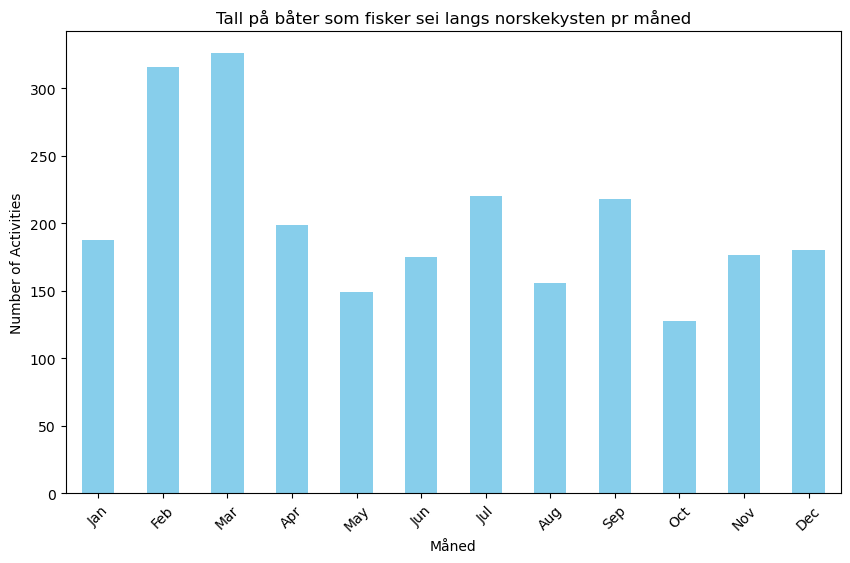

In [417]:
# Teller månedlig aktivitet.
monthly_counts = grouped_df.groupby('Month').size()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr måned')
plt.xlabel('Måned')
plt.ylabel('Number of Activities')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()



Vi ser her at det er mer aktivitet rundt seifiske i månedene februar og mars langs norskekysten. Det kan tenkes at dette har sammenheng med lofotfisket som foregår i månedene februar - april. 

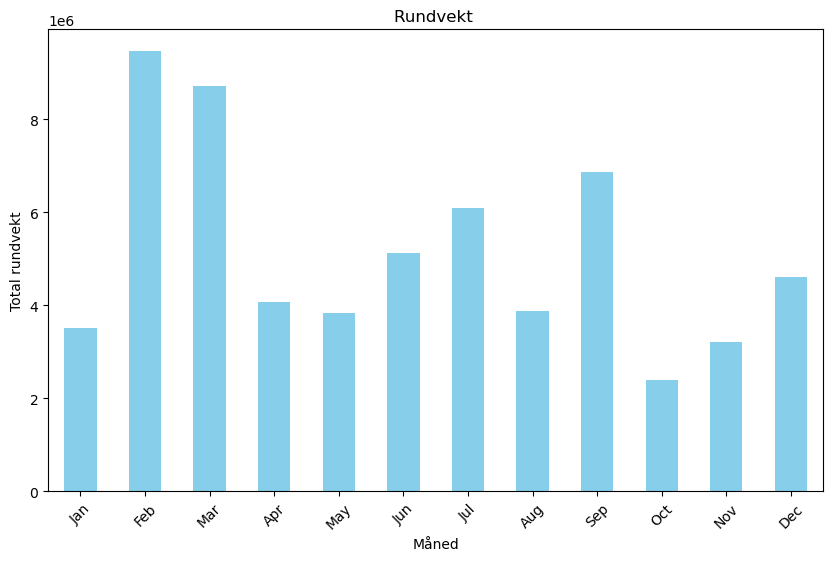

In [418]:
# Finner månedlig total rundvekt
monthly_weights = grouped_df.groupby('Month')['Rundvekt'].sum()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt ')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### 1.6.5 Samlet rundvekt av aktivitetene pr måned
Her ser vi tydelig sammenheng mellom månedene med stor aktivitet og den samlede rundvekten av aktivitetene.

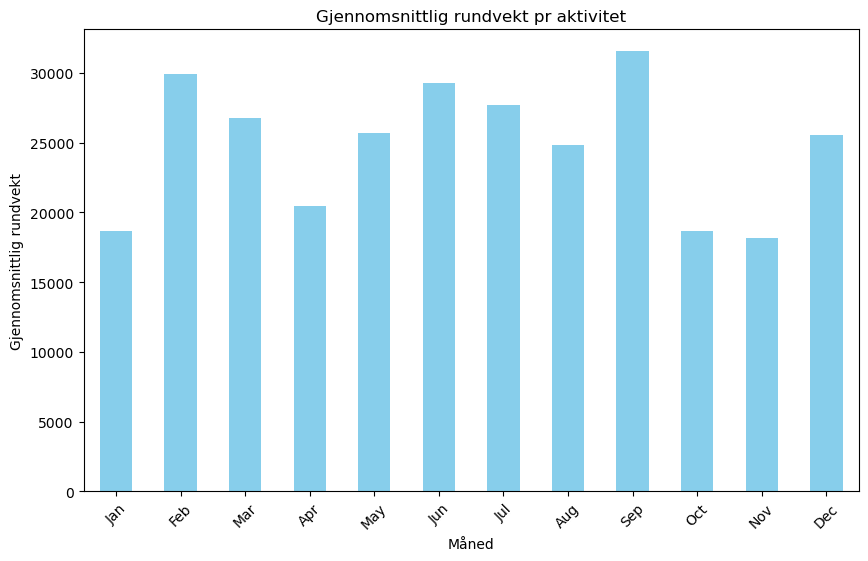

In [419]:
# Regner ut gjenomsnitt pr time
average_weights = monthly_weights/monthly_counts

# Oppretter en serie for alle timene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(average_weights.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr aktivitet')
plt.xlabel('Måned')
plt.ylabel('Gjennomsnittlig rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Ser at gjennomsnittlig vekt av seifiske holder seg stabilt i den forstand at den forventede fangsten holder seg relativt jevn gjennom året.
September utmerker seg likevel som en måned hvor det er forventet mer fisk.

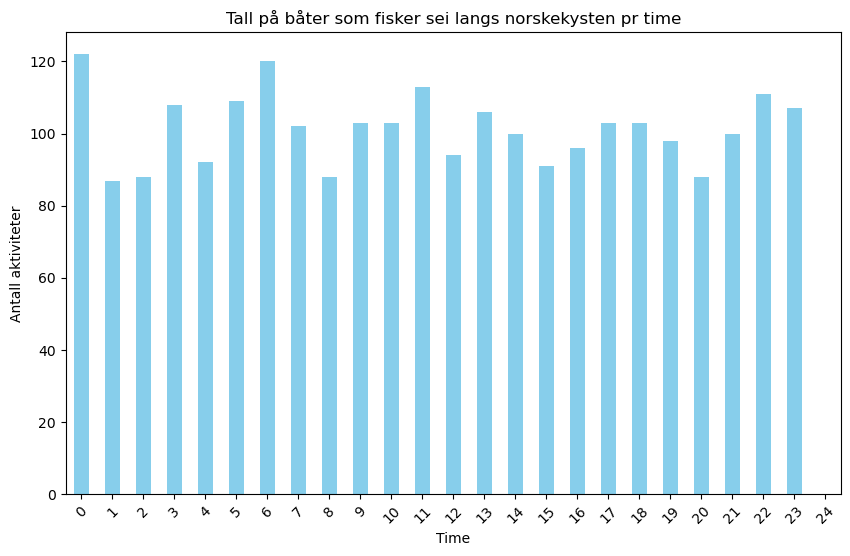

In [420]:
# Regner ut gjenomsnitt pr time
hourly_counts = grouped_df.groupby('Hours').size()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr time')
plt.xlabel('Time')
plt.ylabel('Antall aktiviteter')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()


Her ser vi hvordan fiskeaktivitetene av sei varierer i løpet av døgnet. Ser at det er en nokså stabil aktivitet gjennom døgnet. Her hadde vi forventet litt variasjoner.

Det finner det videre interessant å se på forholdet mellom aktivitetene og fangsten.

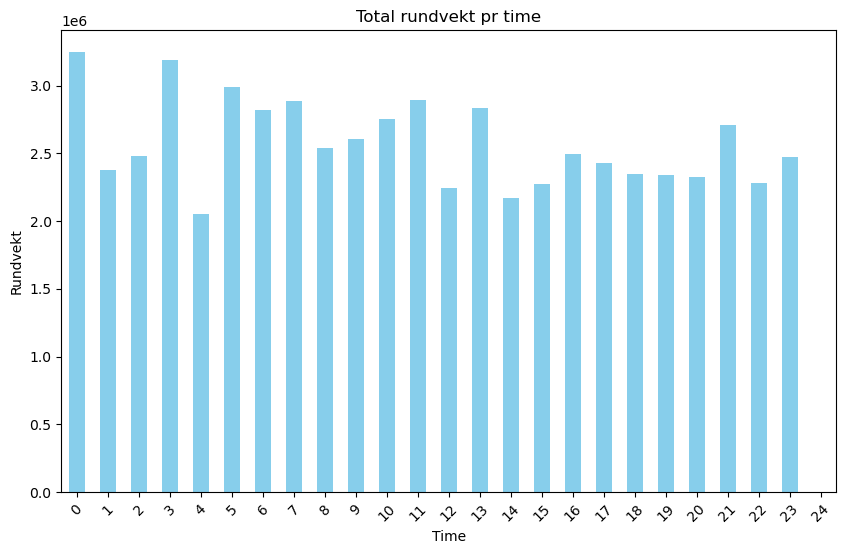

In [421]:
# Regner ut gjenomsnitt pr time
hourly_weights = grouped_df.groupby('Hours')['Rundvekt'].sum()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Total rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

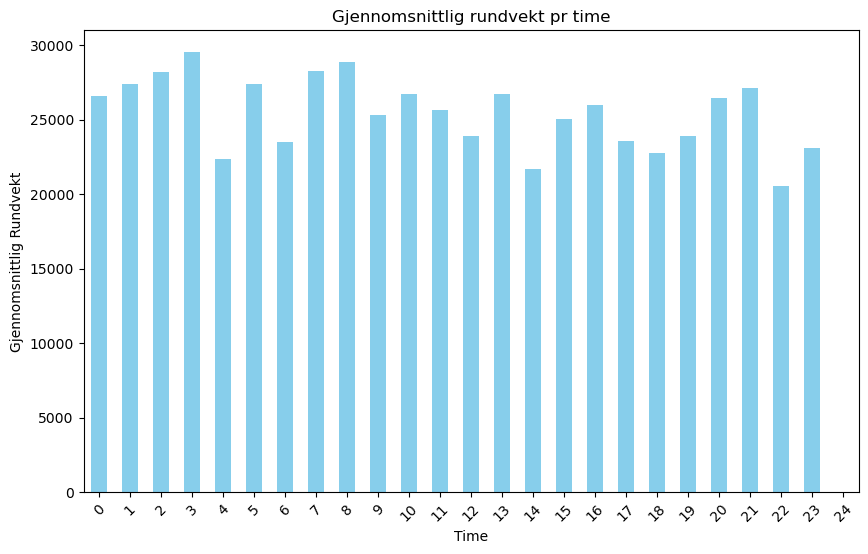

In [422]:
# Regner ut gjenomsnitt pr time
hourly_average = hourly_weights/hourly_counts

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_average.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Gjennomsnittlig Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

### 1.6.6 Tolking av data:
Det ser ut som seifisket med bunntrål fordeler seg ganske jevnt ut over døgnet og året, men med litt mer variasjon i løpet av året. Den beste fangsmåneden ser ut til å være i september om man ser på gjennomsnittlig fangst. Om noe forskjell i løpet av døgnet, så ser det ut som det det blir fanget noe mer fisk fra rundt midnatt til og med kl 11. 

Selv om det er lite variasjoner på døgnet, kan det likevel være relevant for å predikere fiske. Det kan tenkes at det kan skyldes at fiske i nordlige deler på sommer eller vinterhalvåret gir naturlig en jevnere fordeling ila døgnet, siden forskjellene på natt og dag er mindre. Kanskje ville disse forskjellene være tydeligere i mer sørlige områder.


### 1.6.7 Omforming av tid

Om man skal bruke tid på døgnet må vi omforme dataene.
Maskinen og modellene vil tolke 00.01 og 23.59 som to verdier som er veldig langt ifra hverandre. Ved å omregne til sinus/radian løses dette, og vi får mer "sykliske" data.

In [423]:
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M').dt.strftime('%H-%M')
# Konverter til Desimal-timer.
grouped_df['Startklokkeslett_DecimalHours'] = grouped_df['Startklokkeslett'].str.split('-').apply(lambda x: int(x[0]) + int(x[1]) / 60)
# Konverter til Radianer.
grouped_df['Startklokkeslett_Radians'] = grouped_df['Startklokkeslett_DecimalHours'] * (2 * np.pi / 24)
grouped_df.head()

Melding ID Meldingstidspunkt Meldingsdato Meldingsklokkeslett  \
0     1497341  01.01.2018 23:30   2018-01-01               23:30   
1     1497435  02.01.2018 07:50   2018-01-02               07:50   
2     1497823  02.01.2018 23:31   2018-01-02               23:31   
3     1497827  02.01.2018 23:31   2018-01-02               23:31   
4     1497843  02.01.2018 23:45   2018-01-02               23:45   

     Starttidspunkt   Startdato Startklokkeslett  Startposisjon bredde  \
0  01.01.2018 18:54  01.01.2018            18-54                61.283   
1  01.01.2018 03:21  01.01.2018            03-21                68.256   
2  02.01.2018 00:20  02.01.2018            00-20                68.535   
3  02.01.2018 21:48  02.01.2018            21-48                69.483   
4  02.01.2018 16:52  02.01.2018            16-52                63.122   

   Startposisjon lengde  Hovedområde start (kode)  ...  Bruttotonnasje 1969  \
0                 2.074                      28.0  ...               2053.0   
1                10.828                       5.0  ...               2580.0   
2                11.986                       5.0  ...               2580.0   
3                15.850                       5.0  ...                  NaN   
4                 5.381                       7.0  ...                536.0   

  Bruttotonnasje annen Bredde Fartøylengde  Bruttotonnasje kombinert  \
0                  NaN  13.00        75.50                    2053.0   
1                  NaN  14.60        64.00                    2580.0   
2                  NaN  14.60        64.00                    2580.0   
3                129.0   7.01        25.07                     129.0   
4                  NaN  10.30        33.95                     536.0   

   Bruttotonnasje gruppert  Hours  Month  Startklokkeslett_DecimalHours  \
0                        3     18      1                      18.900000   
1                        3      3      1                       3.350000   
2                        3      0      1                       0.333333   
3                        1     21      1                      21.800000   
4                        1     16      1                      16.866667   

  Startklokkeslett_Radians  
0                 4.948008  
1                 0.877028  
2                 0.087266  
3                 5.707227  
4                 4.415683  

[5 rows x 34 columns]

## 1.7: Slette kolonner
Datasettet vi arbeider med inneholder en stor mengde overflødig eller gjentakende informasjon som ikke er relevant videre. Vi har blant annet sett at informasjon om bruttotonnasje er fordelt på to kolonner. Vi har tidligere opprettet en ny kolonne hvor verdiene i disse to er kombinert. Vi kan dermed filtrere bort de opprinnelige kolonnene for bruttotonnasje videre. 

Videre finnes det kolonner hvor dataene ikke er relevante. Dette gjelder blant annet tidspunkt for når meldingen er registrert, som ikke brukes til å predikere fiske i dette tilfellet, da meldingen kan ha vært sendt på et helt annet tidspunkt enn når fisket er gjennomført. Vi er interessert i faktisk tidspunkt og posisjon for fisket for å kunne si noe om resultater fra fisket.

Kolonner vi ikke ser som aktuelle å bruke videre vil nå slettes.


In [424]:
grouped_df.columns


Index(['Melding ID', 'Meldingstidspunkt', 'Meldingsdato',
       'Meldingsklokkeslett', 'Starttidspunkt', 'Startdato',
       'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Havdybde start', 'Stopptidspunkt',
       'Stoppdato', 'Stoppklokkeslett', 'Varighet', 'Stopposisjon bredde',
       'Stopposisjon lengde', 'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR',
       'Hovedart FAO', 'Rundvekt', 'Lengdegruppe (kode)', 'Lengdegruppe',
       'Bruttotonnasje 1969', 'Bruttotonnasje annen', 'Bredde', 'Fartøylengde',
       'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert', 'Hours', 'Month',
       'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians'],
      dtype='object')

In [425]:

# Dropper kolonner: Vi hasher ut de kolonnene vi vil beholde.
grouped_df = grouped_df.drop(columns=[
    'Melding ID', 
    'Meldingstidspunkt', 
    'Meldingsdato', 
    'Meldingsklokkeslett', 
    'Starttidspunkt', 
    'Startdato', 
    'Startklokkeslett', # har konvertert
    #'Startposisjon bredde', 
    #'Startposisjon lengde', 
    'Hovedområde start (kode)', 
    #'Havdybde start', 
    'Stopptidspunkt', # Vi antar at det er liten forskjell på start og sluttidspunkt, så vi velger å droppe disse.
    'Stoppdato', 
    'Stoppklokkeslett', 
    'Varighet', 
    'Stopposisjon bredde', 
    'Stopposisjon lengde', 
    #'Havdybde stopp', Kan være interessant å se på senere
    #'Trekkavstand', 
    #'Redskap FDIR', 
    #'Hovedart - FDIR (kode)', 
    #'Rundvekt', 
    'Lengdegruppe (kode)', 
    'Lengdegruppe', 
    'Bruttotonnasje 1969', 
    'Bruttotonnasje annen', 
    'Bredde', 
    'Fartøylengde', 
    #'Bruttotonnasje kombinert', 
    # Bruttotonnasje gruppert,
    'Hours', 
    #'Month', Tar med måned videre.
    #'Startklokkeslett_DecimalHours',
    #'Startklokkeslett_Radians'
    ])

grouped_df.describe()

Startposisjon bredde  Startposisjon lengde  Havdybde start  \
count           2432.000000           2432.000000     2432.000000   
mean              66.995896             13.538508     -195.995477   
std                4.117422              8.436722       70.709232   
min               60.003000              2.006000     -761.000000   
25%               62.935500              5.328000     -232.000000   
50%               69.278500             15.349000     -187.500000   
75%               70.863000             20.605250     -153.000000   
max               71.998000             32.279000        1.000000   

       Havdybde stopp   Trekkavstand       Rundvekt  Bruttotonnasje kombinert  \
count     2432.000000    2432.000000    2432.000000               2432.000000   
mean      -196.663651   14002.803043   25392.377878               1956.238076   
std         71.710697   12457.394573   19531.149568               1154.065599   
min      -1276.000000       0.000000      28.000000                129.000000   
25%       -231.000000    5269.000000    9332.000000               1194.000000   
50%       -188.000000   10504.500000   22095.500000               1648.000000   
75%       -151.000000   19874.250000   36960.250000               3104.000000   
max        -72.000000  233749.000000  117423.000000               4427.000000   

             Month  Startklokkeslett_DecimalHours  Startklokkeslett_Radians  
count  2432.000000                    2432.000000               2432.000000  
mean      5.972862                      11.946320                  3.127539  
std       3.477152                       6.964992                  1.823431  
min       1.000000                       0.000000                  0.000000  
25%       3.000000                       6.041667                  1.581705  
50%       6.000000                      11.833333                  3.097959  
75%       9.000000                      17.983333                  4.708026  
max      12.000000                      23.966667                  6.274459

## 1.8: Rense nullverdier og ekstremer
Før vi skal bygge modellene våre, så ønsker vi å rense ut eventuelle nullverdier og ekstremer. Vi starter med en visuell beskrivelse av dataene, for å se etter tydelige avvik som med fordel kan fjernes.

Vi ser av df.describe at det finnes registreringer av rundvekt etter trål med verdien 0. Vi anser dette som feilregistreringer, ettersom en trål normalt soper store havområder. Videre vurderer vi det som lite trolig at et trålfiske har forekommet med 0 i trekkavstand. 

På samme måte er det registreringer på over 200.000 meter. Dette er store avstander for en trål som vanligvis opererer i snittfart på mellom 3,4 (6,3km/h) og 5 knop (9,26 km/h). I en snittfart på 10km/h så vil da trålen bruke over 20 timer. Med så lang varighet vil det være svært ugunstige forhold for fisken. Vi ser og at 5% av registreringene er over 35.446 meter. Her ser vi også at med relativt høy fart, vil aktiviteten ha varighet på nærmere 4 timer. Ved å kutte registreringer over 50000m gir det en god margin på mulige feilregistreringer.

Vi ser videre at det er registrert positive havdybde-verdier. I tillegg er det også registrert aktiviteter på -1276 dybde. Men de aller fleste aktivitetene er registrert mellom -227 og -145 meter. Havforskningsinstituttet (2019) beskriver at "Sei førekjem både pelagisk og som botnfisk, frå 0 til 300 meters djup.". Derfor er det rimelig å anta at dette er enten feilregistreringer eller at fangsten er gjort når trålen er på vei opp av dypet. 

Til slutt slås breddegrad og lengdegrad sammen til en posisjon, samt havdybde start og stopp.



Ser av trekkavstand at det i 0-registreringene av trekkavstand også fanges fisk. Dette gir ikke mening med tanke på at det følgelig må trekkes en viss avstand for å få fisk.

Ser også her at det er registrert forskjellige arter i 0-registrerningene på rundvekt. Det er da fornuftig å anta at dette enten er feilregistreringer eller fangst uten betydning.

In [426]:
# Får oversikt av de ulike verdiene:
print(grouped_df.info())
print(grouped_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2432 non-null   float64 
 1   Startposisjon lengde           2432 non-null   float64 
 2   Havdybde start                 2432 non-null   int64   
 3   Havdybde stopp                 2432 non-null   int64   
 4   Trekkavstand                   2432 non-null   float64 
 5   Redskap FDIR                   2432 non-null   object  
 6   Hovedart FAO                   2432 non-null   object  
 7   Rundvekt                       2432 non-null   float64 
 8   Bruttotonnasje kombinert       2432 non-null   float64 
 9   Bruttotonnasje gruppert        2353 non-null   category
 10  Month                          2432 non-null   int32   
 11  Startklokkeslett_DecimalHours  2432 non-null   float64 
 12  Startklokkeslett_Radians       243

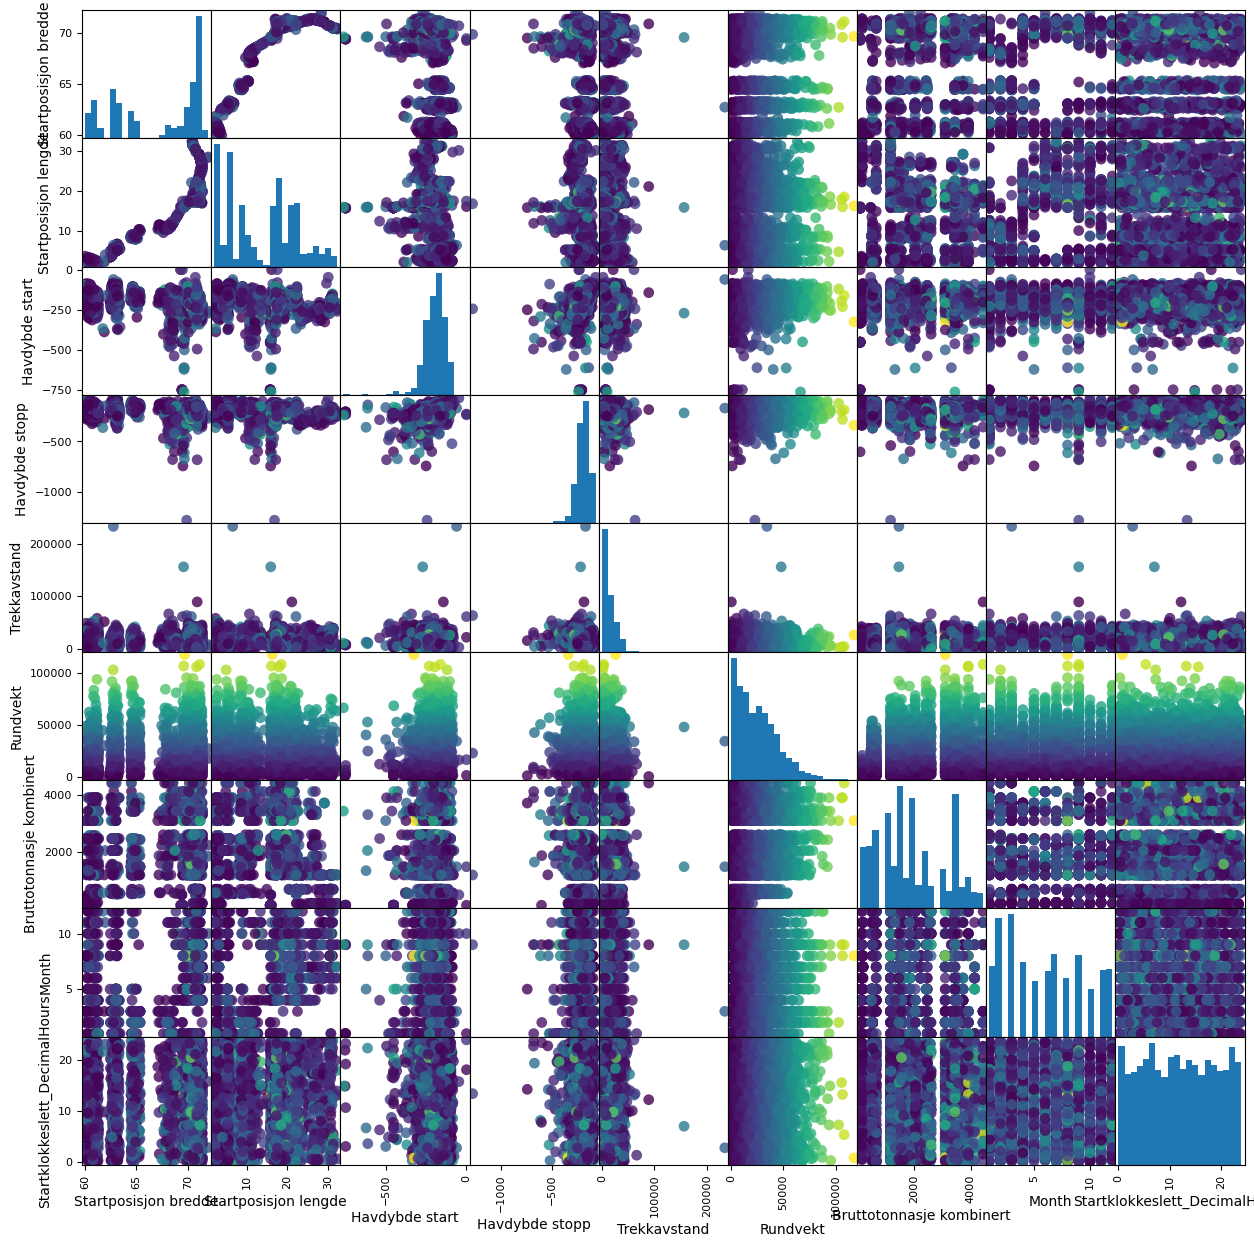

In [427]:
# Inkluderer de numeriske kolonnene
numeric_columns = ['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Rundvekt', 'Bruttotonnasje kombinert',
       'Month', 'Startklokkeslett_DecimalHours']
plot_frame = grouped_df[numeric_columns]  

# Genererer scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )

In [428]:
# Fjerner radene ekstremverdier og konverterer havdybdekolonnen:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
cleaned_df['Havdybde start'] = cleaned_df['Havdybde start'].abs()
# fjerne havdybder over 700
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] < 500]
cleaned_df = cleaned_df[cleaned_df['Havdybde start'] < 500]
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over 50000 m.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 0) & (cleaned_df['Trekkavstand'] < 50000)]
# Droppe Rundvekt med nullverdier:
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] > 0]
# Droppe rundvekt med registreringer over 115000
cleaned_df = cleaned_df[cleaned_df['Rundvekt'] < 115000]


# Droppe ekstreme Bruttotonnasjeverdier.
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Startposisjon lengde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2168 entries, 0 to 2431
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2168 non-null   float64 
 1   Startposisjon lengde           2168 non-null   float64 
 2   Havdybde start                 2168 non-null   int64   
 3   Havdybde stopp                 2168 non-null   int64   
 4   Trekkavstand                   2168 non-null   float64 
 5   Redskap FDIR                   2168 non-null   object  
 6   Hovedart FAO                   2168 non-null   object  
 7   Rundvekt                       2168 non-null   float64 
 8   Bruttotonnasje kombinert       2168 non-null   float64 
 9   Bruttotonnasje gruppert        2168 non-null   category
 10  Month                          2168 non-null   int32   
 11  Startklokkeslett_DecimalHours  2168 non-null   float64 
 12  Startklokkeslett_Radians       2168 non

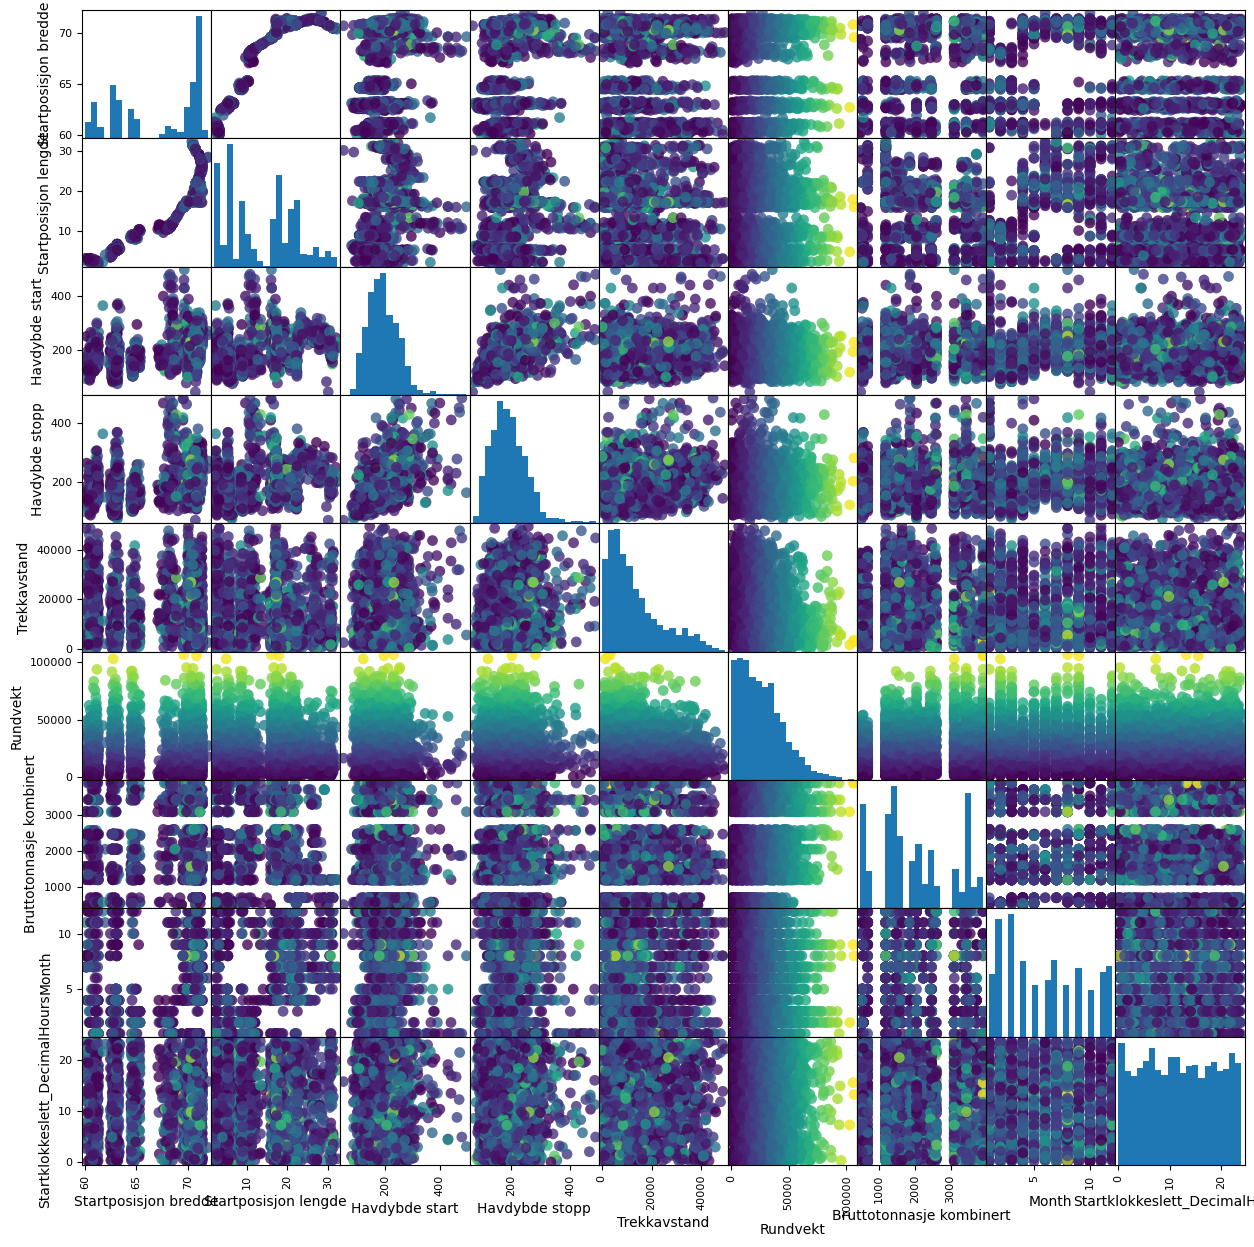

In [429]:
plot_frame = cleaned_df[numeric_columns] 

grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
    )

### Dimensjonel reduksjon:

In [430]:
from sklearn.decomposition import PCA
# Normalize the data
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(cleaned_df[['Startposisjon lengde', 'Startposisjon bredde']])

# Apply PCA
pca = PCA(n_components=1)
cleaned_df['position'] = pca.fit_transform(coords_scaled)

month_time_scaled = scaler.fit_transform(cleaned_df[['Month', 'Startklokkeslett_Radians']])
# Konvertere måned og time - Med tanke på at det kanskje er sammenheng mellom beste klokkeslett og når på året en fisker. 
# For eksempel på vinter er det mørkere, og det kan kanskje påvirke ideelle tidspunkt for fiske:
cleaned_df['Month/time'] = pca.fit_transform(month_time_scaled)

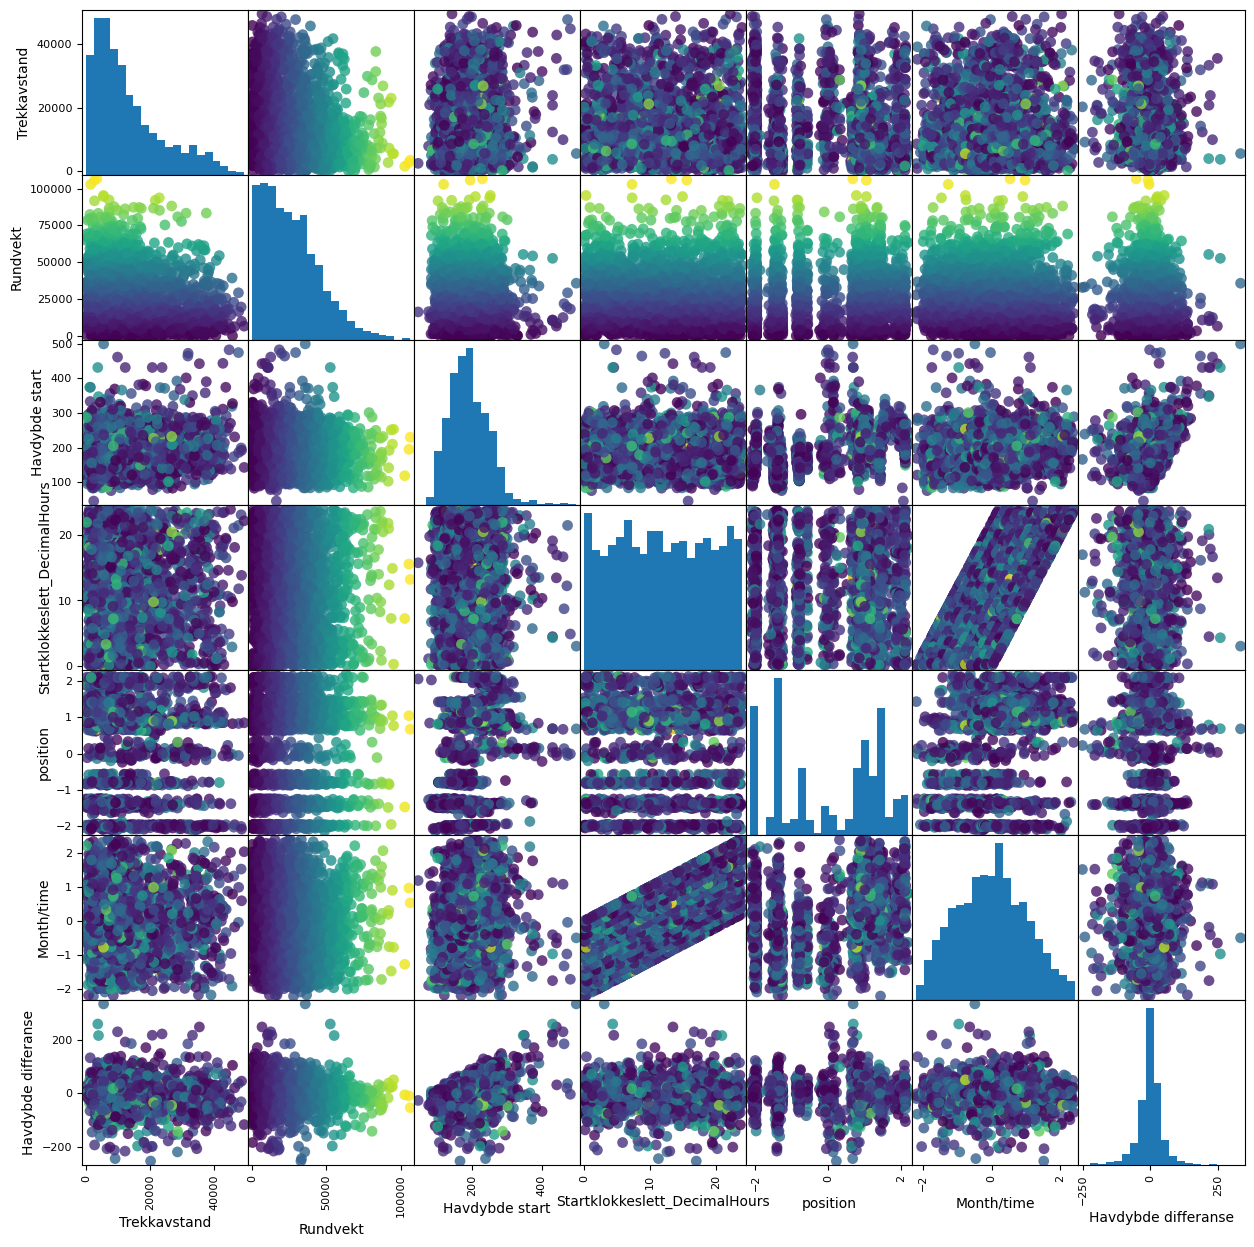

In [431]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['Havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']

features = ['Trekkavstand', 'Rundvekt', 'Havdybde start', 'Startklokkeslett_DecimalHours', 'position', 'Month/time', 'Havdybde differanse']
plot_frame = cleaned_df[features]

# Generate the scatter matrix plot
grr = pd.plotting.scatter_matrix(
    plot_frame, c=plot_frame['Rundvekt'], figsize=(15, 15), marker='o', hist_kwds={'bins':20}, s=60, alpha=.8
)

In [432]:
# Fjerner ekstremer fra den nye kolonnen
cleaned_df = cleaned_df[(cleaned_df['Havdybde differanse'] > -150) & (cleaned_df['Havdybde differanse'] < 150)]

value_counts viser at de mest vanlige redskapene er bunntrål og snurrevad.

# 2: Supervised learning

## 2.1: KNN
Vi har valgt å starte med en KNN-Classifier modell. KNN kan beskrives som den enkleste maskinlæringsmodellen. Vi har valgt tidligere å fjerne ekstreme data, og vil og skalere dataen i denne modellen (Müller & Guido, 2017). Grunnen til at vi har valgt å begynne med en KNN-Classifier er fordi disse modellene er enkle å forstå og er en god start i prosessen for å gi en pekepinn videre på hvilke andre modeller som kan være aktuelle og hvilke justeringer som må gjøres. 

In [433]:
# printer litt info om kolonnene
print(cleaned_df.columns)
print(cleaned_df.info())

Index(['Startposisjon bredde', 'Startposisjon lengde', 'Havdybde start',
       'Havdybde stopp', 'Trekkavstand', 'Redskap FDIR', 'Hovedart FAO',
       'Rundvekt', 'Bruttotonnasje kombinert', 'Bruttotonnasje gruppert',
       'Month', 'Startklokkeslett_DecimalHours', 'Startklokkeslett_Radians',
       'position', 'Month/time', 'Havdybde differanse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 2131 entries, 0 to 2431
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Startposisjon bredde           2131 non-null   float64 
 1   Startposisjon lengde           2131 non-null   float64 
 2   Havdybde start                 2131 non-null   int64   
 3   Havdybde stopp                 2131 non-null   int64   
 4   Trekkavstand                   2131 non-null   float64 
 5   Redskap FDIR                   2131 non-null   object  
 6   Hovedart FAO                 

In [434]:
# Lager kolonne som tar ser om trålen dras i oppoverbakke eller nedoverbakke.
cleaned_df['havdybde differanse'] = cleaned_df['Havdybde start'].abs()-cleaned_df['Havdybde stopp']
#cleaned_df['Startposisjon bredde'] = cleaned_df['Stopp']
cleaned_df['havdybde differanse'].value_counts()

havdybde differanse
 0      54
-1      44
 1      43
 8      39
-3      39
        ..
-76      1
-63      1
-80      1
-91      1
-124     1
Name: count, Length: 242, dtype: int64

In [435]:
# Velger aktuelle features:
selected_features = [
    'Trekkavstand',
    'Bruttotonnasje kombinert', 
    'position', 
    'Month/time',
    'Havdybde differanse',
    'Havdybde start'
    ]
# Kan ikke bruke rundvekt som target i knn-classifier, så vi må konvertere til kategorisk data.
target = ['Rundvekt']

### Q-binning

In [436]:
# Grupperer rundvekt i fire kategorier, for at den skal kunne brukes med kNN-klassifier
labels = ['bad catch', 'Below Average', 'Above average', 'Good catch']

num_bins = 4  # Antall grupper
labels = ['Q1', 'Q2', 'Q3', 'Q4']  # lager fire grupper
cleaned_df['Q-binned'] = pd.qcut(cleaned_df['Rundvekt'], q=num_bins, labels=labels)
cleaned_df['Q-binned'].value_counts()

Q-binned
Q1    533
Q2    533
Q4    533
Q3    532
Name: count, dtype: int64

In [437]:
# Kalkulerer gjennomsnittsrundvekten.
mean_catch_weight = cleaned_df['Rundvekt'].mean()
# Finner standardavviket.
std_dev_catch_weight = cleaned_df['Rundvekt'].std()

# Definerer bins, basert på standardavvik.
lower_bound = mean_catch_weight - std_dev_catch_weight
upper_bound = mean_catch_weight + std_dev_catch_weight

cleaned_df['std-binned'] = pd.cut(cleaned_df['Rundvekt'], 
                                      bins=[-np.inf, lower_bound, mean_catch_weight, upper_bound, np.inf], 
                                      labels=labels)

print('Standardfordeling:', std_dev_catch_weight)
print('Gjennomsnittsfangst:', mean_catch_weight)

cleaned_df[['std-binned']].value_counts()

Standardfordeling: 19111.172743704275
Gjennomsnittsfangst: 26668.509150633505


std-binned
Q2            827
Q3            619
Q1            352
Q4            333
Name: count, dtype: int64

In [438]:
# Setter target til Q-binned.
target = 'Q-binned'

X = cleaned_df[selected_features]
y = cleaned_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  

Scaling

Min-max

prøver ut Min-max på Q-binned

In [439]:
# Setter target til Q-binned.
target = 'Q-binned'

X = cleaned_df[selected_features]
y = cleaned_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  

In [440]:
# Scale features (for kNN)
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [441]:
# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")

KNN Classifier Score: 0.297423887587822


### Standardscaler:

Forsøker på nytt med standardscaler

In [442]:
# Skalerer
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")

KNN Classifier Score: 0.2810304449648712


Ser at Min-max scorer noe bedre enn standardscaler

### Tester std-binned target

Tester standardfordelte grupper for målverdi:

In [443]:
# Setter target til std-fordelt gruppering std-binned.
new_target = 'std-binned'

# Setter scaler tilbake til min-max
scaler = MinMaxScaler(feature_range=(0,1))
X = cleaned_df[selected_features]
y = cleaned_df[new_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)  

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train_encoded)
y_pred_knn_classifier = knn_classifier.predict(X_test_scaled)

# Evaluate the classifier
accuracy = accuracy_score(y_test_encoded, y_pred_knn_classifier)
print(f"KNN Classifier Score: {accuracy}")


KNN Classifier Score: 0.37236533957845436


In [444]:
# Genererer en dictionary med parameterene vi vil tune. Hvor mange naboer, algoritme, 
# Hvordan modellen vektlegger og hvordan modellen regner avstand.
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Genererer gridsearch-objekt
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# fitting.
grid_search.fit(X_train_scaled, y_train_encoded)
# Finner beste resultat
best_knn = grid_search.best_estimator_
# Predikerer ved bruk av beste modell.
y_pred = best_knn.predict(X_test_scaled)

# Skriver ut score.
accuracy = accuracy_score(y_test_encoded, y_pred)
print(
    f'Beste kNN Classifier Score med :\n Naboer: {best_knn.n_neighbors}\n Vekter: "{best_knn.weights}"\n Metric: "{best_knn.metric}"\n Algoritme: "{best_knn.algorithm}"\nNøyaktighet: "{accuracy}"'
      )

Beste kNN Classifier Score med :
 Naboer: 10
 Vekter: "distance"
 Metric: "manhattan"
 Algoritme: "ball_tree"
Nøyaktighet: "0.34660421545667447"


## 2.2 Desicion tree Classifier
Decision trees er en supervised læringsmodell som bade blir brukt til klassifikasjon og regresjon. Den fungerer ved at den stiller en rekke «hvis/hvis ikke-spørsmål» for å komme fram til en «beslutning», altså en klasse eller en verdi (Müller & Guido, 2017). 

In [445]:
# Create Decision Tree classifier object
dtree = DecisionTreeClassifier(max_depth=3, criterion='gini')

# Fit the model to the training data
dtree.fit(X_train, y_train)

# Make predictions
y_pred = dtree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Decision Tree classifier: {accuracy:.2f}")


Accuracy of Decision Tree classifier: 0.38


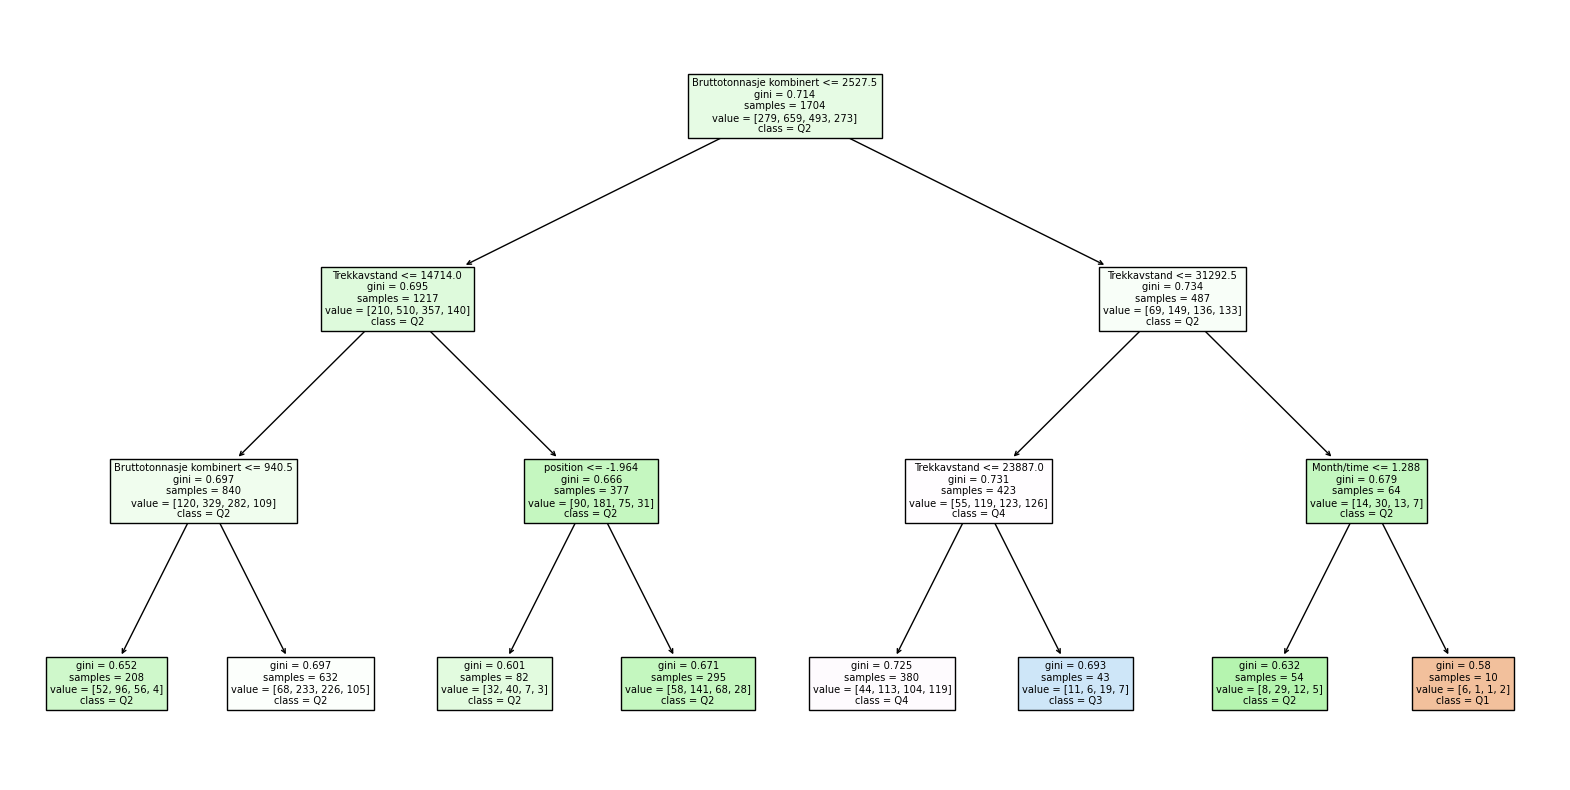

In [447]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))  # Adjust the size to fit your needs
plot_tree(dtree, filled=True, feature_names=selected_features, class_names=labels)
plt.show()

In [ ]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)


In [ ]:
cleaned_df.head()

Startposisjon bredde  Startposisjon lengde  Havdybde start  Havdybde stopp  \
0                61.283                 2.074             182             180   
2                68.535                11.986             285             148   
4                63.122                 5.381             280             311   
5                61.221                 2.181             167             193   
6                63.113                 5.346             199             266   

   Trekkavstand Redskap FDIR Hovedart FAO  Rundvekt  Bruttotonnasje kombinert  \
0       16590.0     Bunntrål          Sei    3000.0                    2053.0   
2       35125.0     Bunntrål          Sei   17053.0                    2580.0   
4       34192.0     Bunntrål          Sei    1445.0                     536.0   
5       36931.0     Bunntrål          Sei   24100.0                    2053.0   
6        8426.0     Bunntrål          Sei   14410.0                     536.0   

  Bruttotonnasje gruppert  Month  Startklokkeslett_DecimalHours  \
0                       3      1                      18.900000   
2                       3      1                       0.333333   
4                       1      1                      16.866667   
5                       3      1                      12.000000   
6                       1      1                      13.583333   

   Startklokkeslett_Radians  position  Month/time  Havdybde differanse  \
0                  4.948008 -1.976391   -0.308279                    2   
2                  0.087266  0.137589   -2.193823                  137   
4                  4.415683 -1.372625   -0.514775                  -31   
5                  3.141593 -1.978106   -1.009011                  -26   
6                  3.556108 -1.377185   -0.848215                  -67   

   havdybde differanse Q-binned std-binned  
0                    2       Q1         Q1  
2                  137       Q2         Q2  
4                  -31       Q1         Q1  
5                  -26       Q3         Q2  
6                  -67       Q2         Q2

In [ ]:
from sklearn.metrics import mean_absolute_error
# Endrer til rundvekt for flytende tallverdier.

target = 'Rundvekt'
X = cleaned_df[selected_features]
y = cleaned_df[target]
# Splitter settet i trainsett og testsett - Da kan man sammenligne prediksjonene mot et test-sett
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
# Velger MLmodell
fishery_model = DecisionTreeRegressor(random_state=1)
# Trener(?) modellen på train-settet

fishery_model.fit(X_train, y_train)
# Prediksjoner - predikerer tar X-val verdiene og predikerer rundvekt basert på disse tallene.
val_predictions = fishery_model.predict(X_val)
# Sammenligner et utvalg (X-val.head()) av prediksjoner mot relaterte y_val.head()
print(fishery_model.predict(X_val.head()))
print(y_val.head())

# Tar inn y_val verdiene og regner ut gjennomsnittlig feil mellom prediksjonene og test-verdiene(val_y)
val_mae = mean_absolute_error(y_val, val_predictions)
print(f'\nMean absolute error: {val_mae}')
print(f'\nScore: {fishery_model.score(X_val, y_val)}\n')

[14253. 47491.   655. 37023. 62673.]
1372     1779.0
518     15024.0
1666    38941.0
1724    49863.0
1386    79568.0
Name: Rundvekt, dtype: float64

Mean absolute error: 20171.724705882352

Score: -0.851396712195652



## 2.3: Linear regression:


Vi ser her på om en linær regresjonsmodell kan brukes til å predikere rundvekt.

In [ ]:
data = cleaned_df[features]
predict = 'Rundvekt'

y = cleaned_df[predict]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.08573052647680512


Vi ser at Lineær regresjonsmodell gir lav score, som indikerer at den ikke predikerer rundvekt presist. 

## 2.4: MLP regressor


In [ ]:
import numpy as np
import pandas as pd
# import sklearn.datasets as data

In [ ]:
df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')
df.head()
print(df.shape)

(305434, 45)


Droppet Meldingstidspunkt, Starttidspunkt, Art - FDIR og strings fra dataset grunnet hvordan dataskalering generelt ikke liker strings.
Etter å ha droppet disse gikk scoren fra -11% til 20% i både i test og train settet


In [ ]:
#Sile ut informasjon:
df = df[(df['Art - FDIR (kode)'] == 1022) | (df['Art - FDIR (kode)'] == 1027)] # Fiske som fanger hyse eller torsk. "751 - lodde, 1022 Torsk"
area = [7, 8, 28, 30, 40]
df = df[(df['Redskap FDIR (kode)'] == 51) & (df['Hovedområde start (kode)'].isin(area))] # Fiske med bunntrål - 51, snurrevad - 11
df['Bruttotonnasje Kombinert'] = df['Bruttotonnasje 1969'].fillna(df['Bruttotonnasje annen']) # Slår sammen kolonnene.
# Dropper unødvendig informasjon. Tabellen inneholder masse duplikater. som egen kolonne for navn og for kode
# Forskjellige klassifiseringsmåter. Holder på FDIR sine.

# Normal pre-processing som vi gjorde på alt annet
df.drop(columns = ['Meldingsdato', 
                   'Meldingsklokkeslett', 
                   'Startdato',  
                   'Hovedområde start', 
                   'Lokasjon start (kode)', 
                   'Stoppdato', 
                   'Stoppklokkeslett', 
                   'Fangstår', 
                   'Hovedområde stopp (kode)', 
                   'Hovedområde stopp', 
                   'Lokasjon stopp (kode)', 
                   'Redskap FAO (kode)', 
                   'Redskap FAO', 
                   'Redskap FDIR', 
                   'Hovedart FAO (kode)', 
                   'Hovedart FAO', 
                   'Art FAO (kode)',
                   'Art FAO',
                   'Art - gruppe', 
                   'Lengdegruppe', 
                   'Bredde', 
                   'Fartøylengde',
                   'Bruttotonnasje 1969',
                   'Bruttotonnasje annen',

                    #kolonner fjernet for MLP regressor
                   'Meldingstidspunkt',
                   'Starttidspunkt',
                   'Startklokkeslett',
                   'Stopptidspunkt',
                   'Art - FDIR',
                   'Melding ID',
                   'Havdybde start',# Filter and remove incorrect values
                   'Havdybde stopp',# Filter and remove incorrect values
                   'Redskap FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
                    'Hovedart - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
                    'Art - FDIR (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
                    'Art - gruppe (kode)', #Fjernet grunnet gjentagene data som ikke gav noe verdi
    ], inplace=True)

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
df['Bruttotonnasje Gruppert'] = pd.cut(df['Bruttotonnasje Kombinert'], bins=bins, labels=labels)
# Teller grupperingene
df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
6     992
3     950
2     618
21    465
4     433
35    312
14    305
32    261
5     257
25    233
1     210
12    191
16    186
15    181
40    164
38     78
26     50
7      49
23     45
19     44
45     17
17      8
42      5
44      0
46      0
41      0
33      0
37      0
36      0
43      0
34      0
39      0
24      0
31      0
30      0
29      0
28      0
27      0
22      0
20      0
18      0
13      0
11      0
10      0
9       0
8       0
47      0
Name: count, dtype: int64

In [ ]:
df.head()

Startposisjon bredde  Startposisjon lengde  Hovedområde start (kode)  \
353                 57.588                 6.834                       8.0   
635                 61.221                 2.181                      28.0   
1000                58.318                 6.210                       8.0   
1001                58.318                 6.210                       8.0   
1149                63.411                 5.656                       7.0   

      Varighet  Stopposisjon bredde  Stopposisjon lengde  Trekkavstand  \
353        692               57.534                7.466       38303.0   
635        330               61.481                1.753       36931.0   
1000        71               58.328                6.200        1259.0   
1001        71               58.328                6.200        1259.0   
1149       302               63.346                5.699        7558.0   

      Rundvekt  Lengdegruppe (kode)  Bruttotonnasje Kombinert  \
353      114.0                  4.0                     267.0   
635      100.0                  5.0                    2053.0   
1000      10.0                  3.0                      79.0   
1001       8.0                  3.0                      79.0   
1149      72.0                  5.0                     536.0   

     Bruttotonnasje Gruppert  
353                        3  
635                       21  
1000                       1  
1001                       1  
1149                       6

In [ ]:
print(df.shape)
df.head()
y = df['Rundvekt'] 
X = df.drop('Rundvekt', axis=1) #Dropper rundvekt pga det er hva jeg trener modellen på


(6054, 11)


In [ ]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=200, random_state=1)
# print(X,y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #Test størrelse = 20% av datasettet

In [ ]:
#MinMax Scaler fungerer best med MLP regressor grunnet at verdier som er ekstremt høye/lav kan føre til kluss i loss kalkuleringen

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.fit_transform(X_test)

# print(X)

In [ ]:
#Mildt sakt, standard scaler fungerte svært dårlig

# from sklearn.preprocessing import StandardScaler
# sc=StandardScaler()

# scaler = sc.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes = [20,10], #Første lag har 20 neurons, andre lag har 10. 
                  activation = 'relu', alpha = 0.1, 
                  max_iter = 2000, #Maks itterasjoner du gjør men det er egentlig epocs. usikker på hvorfor de bruker 'itterations' og not 'epocs'
                #   early_stopping=True, #Early stopping introduserte ustabilitet. men med en iter på 2000 maks så skal det ikke ta alt for lang tid på de fleste pcer.
                  learning_rate_init=0.1,#Start på learning rate, den blir adaptet etter hvert angående på loss verdien
                  learning_rate="adaptive",
                  solver = 'adam', 
                  verbose = False)


In [ ]:

#Test skår uten data leak. (bruker minmax etter splitting)
nn.fit(X_train_minmax, y_train)
print("Neural network, MLPRegressor")
print("Test score",  nn.score(X_test_minmax, y_test))
print("Train  score", nn.score(X_train_minmax, y_train))


Neural network, MLPRegressor
Test score 0.6644181804797435
Train  score 0.9229676941859752


**Resultat**

Vi observerer at det er et «overfitting» problem i modellen som skaper noen vanskeligheter, dog er resultatene relativt gode.

One-hot encoding kan hjelpe med dette gjennom å få tak i mer data samt strategier som early stopping. Et annet forbedringspotensial hadde vært å få brukt «regularization techniques». 


# 3: Unsupervised learning


## 3.1: Clustering
Vi vil nå utføre en K-means clustering. Målet er å finne «cluster centers» som er representative for noen områder med data. (Müller & Guido, 2017).

In [ ]:
#Importerer nødvendige libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Her preprosesseres dataen på nytt, siden det skal filtreres på andre ting enn i del 1.

Målet med modellen er å predikere hvilke fisk som fanges basert på ulike variabler.

In [ ]:
df_clustering = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')
desired_fish = ['Sei', 'Dypvannsreke', 'Taskekrabbe'] #Ønsket fisk vi vil filtere på
filtered_data = df_clustering[ df_clustering['Art FAO'].isin(desired_fish)] #Beholder kun data på fisketurer hvor det er fisket de ønskede fiskene

features = ["Rundvekt", "Havdybde start", "Havdybde stopp", "Trekkavstand", "Art FAO", ] #liste over de ulike variablene vi ønsker å ha med

ekstra = filtered_data.dropna(subset=features) #Fjerner rader med n/a verdier

data_clustering1 = ekstra[features].copy() 

data_clustering_cleaned =data_clustering1.drop(columns= ['Art FAO']) #Fjerner så alle variabler som er strings


data_clustering_cleaned.head()

FileNotFoundError: [Errno 2] No such file or directory: 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'

In [ ]:
#fjerner outliers

Q1 = data_clustering_cleaned.quantile(0.25)
Q3 = data_clustering_cleaned.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = data_clustering_cleaned[((data_clustering_cleaned < (Q1 - 1.5 * IQR)) | (data_clustering_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)]
clustering_data = data_clustering_cleaned[~data_clustering_cleaned.index.isin(outliers_iqr.index)]


clustering_data.head()

In [ ]:
#Skalerer nødvendig data

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data[['Rundvekt', 'Havdybde start', 'Havdybde stopp', 'Trekkavstand']])

In [ ]:
#Bruker elbow metoden for å finne den optimale k

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(clustering_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Basert på resultatene fra elbow metoden velger vi å sette k=3

In [ ]:
#anvender K-Means clusteringen

k=3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)
#clustering_data['cluster'] = kmeans.labels_
y_pred = kmeans.predict(scaled_data)

Videre visualiseres de ulike clusterene basert på variablene.

In [ ]:
#1. Ser på sammenheng mellom rundvekt og havdybde start
plt.scatter(clustering_data['Rundvekt'], clustering_data['Havdybde start'], c=y_pred, cmap='viridis')
plt.xlabel('Rundvekt')
plt.ylabel('Havdybde start')

plt.title('Clustere av Fiskedata')
plt.show()

In [ ]:
#2. Ser på sammenheng mellom rundvekt og havdybde stopp
plt.scatter(clustering_data['Rundvekt'], clustering_data['Havdybde stopp'], c=y_pred, cmap='viridis')
plt.xlabel('Rundvekt')
plt.ylabel('Havdybde stopp')

plt.title('Clustere av Fiskedata')
plt.show()

In [ ]:
#3. Ser på sammenheng mellom trekkavstand og havdybde start
plt.scatter(clustering_data['Trekkavstand'], clustering_data['Havdybde start'], c=y_pred, cmap='viridis')
plt.xlabel('Trekkavstand')
plt.ylabel('Havdybde start')

plt.title('Clustere av Fiskedata')
plt.show()

In [ ]:
#4. Ser på sammenheng mellom trekkavstand og rundvekt
plt.scatter(clustering_data['Trekkavstand'], clustering_data['Rundvekt'], c=y_pred, cmap='viridis')
plt.xlabel('Trekkavstand')
plt.ylabel('Rundvekt')

plt.title('Clustere av Fiskedata')
plt.show()

**Resultater av clustering**

Basert på de ulike resultatene over, kan diagram 1 og 2 vise tydelige tendenser til clustering. (Havdybde start/stopp mot rundvekt). Basert på clusterne er det rimelig å anta at det er sei som har høyest rundvekt, dypvannsreke er nede til venstre og taskekrabbe øverst til venstre.


# 4: Diskusjon av resultater og konklusjon

# 5: Referanser


Fiskeridirektoratet (2018). Havområder fra 2018. Https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore

Fiskeridirektoratet (2022). Redskapstyper. https://www.fiskeridir.no/Yrkesfiske/Tema/redskapshefte/Redskapshefte.pdf

Havforskningsinstituttet (2019) Tema: Sei i Nordsjøen, Skagerrak og vest av Skottland. https://www.hi.no/hi/temasider/arter/sei-i-nordsjoen

Havforskningsinstituttet (2019). Tema: Sei - Nordaustarktisk. https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei

Muller, A. C & Guido, S (2017). Introduction to Machine Learning with Python: A guide for Data Scientists. O’Reilly Media.

Osnes, A. (2024) Bruttotonn. I Store Norske Leksikon https://snl.no/bruttotonn